# Detectron2

[Main Page](https://ai.meta.com/tools/detectron2/)

In [1]:
install = False

if install:
    !pip3 install torch torchvision torchaudio --upgrade
    !CC=clang CXX=clang++ ARCHFLAGS="-arch arm64" python3 -m pip install 'git+https://github.com/facebookresearch/detectron2.git' --no-build-isolation
    !pip3 install wheel

In [1]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

zsh:1: command not found: nvcc
torch:  2.2 ; cuda:  2.2.2
detectron2: 0.6


In [2]:
# Some basic setup:
# Setup detectron2 logger
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances

In [4]:
register_coco_instances("my_dataset_train", {}, "./BraTS/BraTS2021_Coco/Train/Train.json", "./BraTS/BraTS2021_Coco/Train/")
register_coco_instances("my_dataset_val", {}, "./BraTS/BraTS2021_Coco/Val/Val.json", "./BraTS/BraTS2021_Coco/Val/")

In [6]:
train_metadata = MetadataCatalog.get('my_dataset_train')
train_dataset_dicts = DatasetCatalog.get("my_dataset_train")

[04/02 12:39:54 d2.data.datasets.coco]: Loading ./BraTS/BraTS2021_Coco/Train/Train.json takes 4.14 seconds.
WARNING [04/02 12:39:54 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/02 12:39:55 d2.data.datasets.coco]: Loaded 151721 images in COCO format from ./BraTS/BraTS2021_Coco/Train/Train.json


In [5]:
val_metadata = MetadataCatalog.get('my_dataset_val')
val_dataset_dicts = DatasetCatalog.get("my_dataset_val")

[04/02 12:39:15 d2.data.datasets.coco]: Loading ./BraTS/BraTS2021_Coco/Val/Val.json takes 1.09 seconds.
WARNING [04/02 12:39:15 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/02 12:39:15 d2.data.datasets.coco]: Loaded 42904 images in COCO format from ./BraTS/BraTS2021_Coco/Val/Val.json


[ WARN:0@110.455] global loadsave.cpp:248 findDecoder imread_('./BraTS/BraTS2021_Coco/Train/BraTS2021_00756_flair114.png'): can't open/read file: check file path/integrity


TypeError: 'NoneType' object is not subscriptable

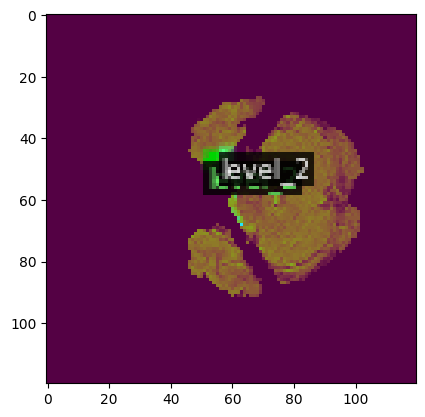

In [8]:


for d in random.sample(train_dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata , scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])

# Define our custom dataset

[Custom Datasets Doc](https://detectron2.readthedocs.io/en/latest/tutorials/datasets.html)

In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "json_annotation_train.json", "path/to/image/dir")
register_coco_instances("my_dataset_val", {}, "json_annotation_val.json", "path/to/image/dir")

In [ ]:
dataset_dicts = get_balloon_dicts("balloon/train")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=balloon_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2.imshow(out.get_image()[:, :, ::-1])

In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("balloon_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

In [ ]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_balloon_dicts("balloon/val")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=balloon_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2.imshow(out.get_image()[:, :, ::-1])

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("balloon_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "balloon_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

See [Colab](https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5#scrollTo=h9tECBQCvMv3) for more.